### Setup

#### Import Packages

In [9]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
sns.set_theme()
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.formula.api import ols
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

#### Reading in CSV to DataFrame

In [347]:
df = pd.read_csv('data/training_data.csv', index_col = 0)

In [348]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
28835,220000,2,1,2,36,0,0,0,0,0,0,222598,222168,217900,221193,181859,184605,10000,8018,10121,6006,10987,143779,1
25329,200000,2,3,2,29,-1,-1,-1,-1,-1,-1,326,326,326,326,326,326,326,326,326,326,326,326,0
18894,180000,2,1,2,27,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
690,80000,1,2,2,32,0,0,0,0,0,0,51372,51872,47593,43882,42256,42527,1853,1700,1522,1548,1488,1500,0
6239,10000,1,2,2,27,0,0,0,0,0,0,8257,7995,4878,5444,2639,2697,2000,1100,600,300,300,1000,1


## Data Cleaning

There is a row that appeared to have column header text as values, which brings me to my first objective: remove that row and convert the remaining values to numeric. I set the new column names to lowercase as well, to ease dataframe manipulation.

- Later, I may want to convert the longer numeric currency values in the several `bill_amt` and `pay_amt` features to float. I can't think of a reason to *need* to do this, but it's a bit peculiar working with currencies as integers. They should be treated as continuous values.
  - Notice that the `limit_bal` column also has currency values. These should be treated as categorical, for reasons which I elaborate further below.
- Below you can see how I handle values that were nonsense or worthless for inferrence.   
- The holdout dataset has been given the same column headers, excluding the target `df['y']`.  

In [369]:
df.columns

Index(['limit_bal', 'male', 'marriage', 'age', 'pay_1', 'pay_2', 'pay_3',
       'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3',
       'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2',
       'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'y', 'hs_edu',
       'uni_edu', 'grad_edu'],
      dtype='object', name='ID')

In [349]:
# CLEANING: changing row 
df.columns = df.loc['ID'] # isolating the row of text that should have been set to column headers
df.columns = df.columns.str.lower() # no need to hit shift to reference columns. so much better
df.rename(columns={'default payment next month': 'y'}, inplace=True) # renaming long column name for our target back to y
df.drop(index='ID', inplace=True) # dropping header row

# CLEANING: changing column datatypes to numeric
df[
    ['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'y']
] = df[
    ['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'y']
].apply(pd.to_numeric) 

# CLEANING: capping balance limits to 500,000
df['limit_bal'] = np.where(df.limit_bal > 500000,
                           500000,
                           df.limit_bal)

# CLEANING/Pseudo FE: changing 'gender' column to male dummy variable
df['sex'] = np.where(df.sex == 2, 
                     0, 
                     df.sex)

# CLEANING: Changing cleaned column name for clarity
df.rename(columns={'sex':'male'}, inplace=True)

# FE: special dummying education in to three distinct features
df['hs_edu'] = np.where(((df.education == 1) |
                         (df.education == 2) |
                         (df.education == 3)),
                           1,
                           0)

df['uni_edu'] = np.where(((df.education == 1) |
                          (df.education == 2)),
                            1,
                            0)

df['grad_edu'] = np.where(df.education == 1,
                           1,
                           0)

# CLEANING: dropping education now that categories have been managed
df.drop(columns='education', inplace=True)

# CLEANING: combining all non-married values, making 'marriage' a binary category
df['marriage'] = np.where(df.marriage == 1,
                           1,
                           0)

# CLEANING: renaming pay_0 to pay_1, consistent with other features that reference 1 for September
df.rename(columns={'pay_0': 'pay_1'}, inplace=True)

# CLEANING: imputing delayed payment ranks to a single value for all months
df['pay_1'] = np.where(df.pay_1 > 0,
                      1,
                      df.pay_1)

df['pay_2'] = np.where(df.pay_2 > 0,
                      1,
                      df.pay_2)

df['pay_3'] = np.where(df.pay_3 > 0,
                      1,
                      df.pay_3)

df['pay_4'] = np.where(df.pay_4 > 0,
                      1,
                      df.pay_4)

df['pay_5'] = np.where(df.pay_5 > 0,
                      1,
                      df.pay_5)

df['pay_6'] = np.where(df.pay_6 > 0,
                      1,
                      df.pay_6)

In [352]:
# Setting variables to be used in the models
X = df.drop('y', axis = 1) # grabs dataset features excluding our target.
y = df['y'] # y is the column we're trying to predict, our 'target'

In [353]:
df.y.value_counts()

0    17471
1     5028
Name: y, dtype: int64

## EDA

- handling null values
- handling categorical variables
- removing unimportant columns 
- removing outliers
- identify opportunities to create new features.

Our target `y` has a mean of 0.223477, revealing that a majority of credit holders in the dataset have not defaulted. The ratio of those who have defaulted to those who have not is roughly $\frac{1}{4.5}$. This should not be significant enough to cause issues related to class imbalance. 
  
Fortunately, there are no null values to manage in the dataset, however as seen above there were several instances where imputing, capping, and manipulating the data were required to prepate them for our model.  
  
As all features appear to be numeric `int` type, it is important to distinguish true numeric values from those to be treated as categorical. I illustrate the distinctions below.  
  
It is difficult to understand the magnitude of each individual's credit status when values are in a foreign currency. Below I have created a new dataframe to compare the values of NT to USD, strictly for my own reference. Actual values of the training dataframe will not be changed.

<u>Categorical Features</u>:
- X1 — **limit_bal**
- X2 — **male**
- X3 — **education**
- X4 — **mariage**
- X6-X11 — **pay_$n$** — retroactive past payment, Sept-April  
  
<u>Quantitative Features</u>:
- X5 — **age**
- X12-X17 — **bill_amt$n$** — retroactive bill statement, Sept-April
- X18-X23 — **pay_amt$n$** — amount of previous payment

In [326]:
df.columns

Index(['limit_bal', 'male', 'marriage', 'age', 'pay_0', 'pay_2', 'pay_3',
       'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3',
       'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2',
       'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'y', 'hs_edu',
       'uni_edu', 'grad_edu'],
      dtype='object', name='ID')

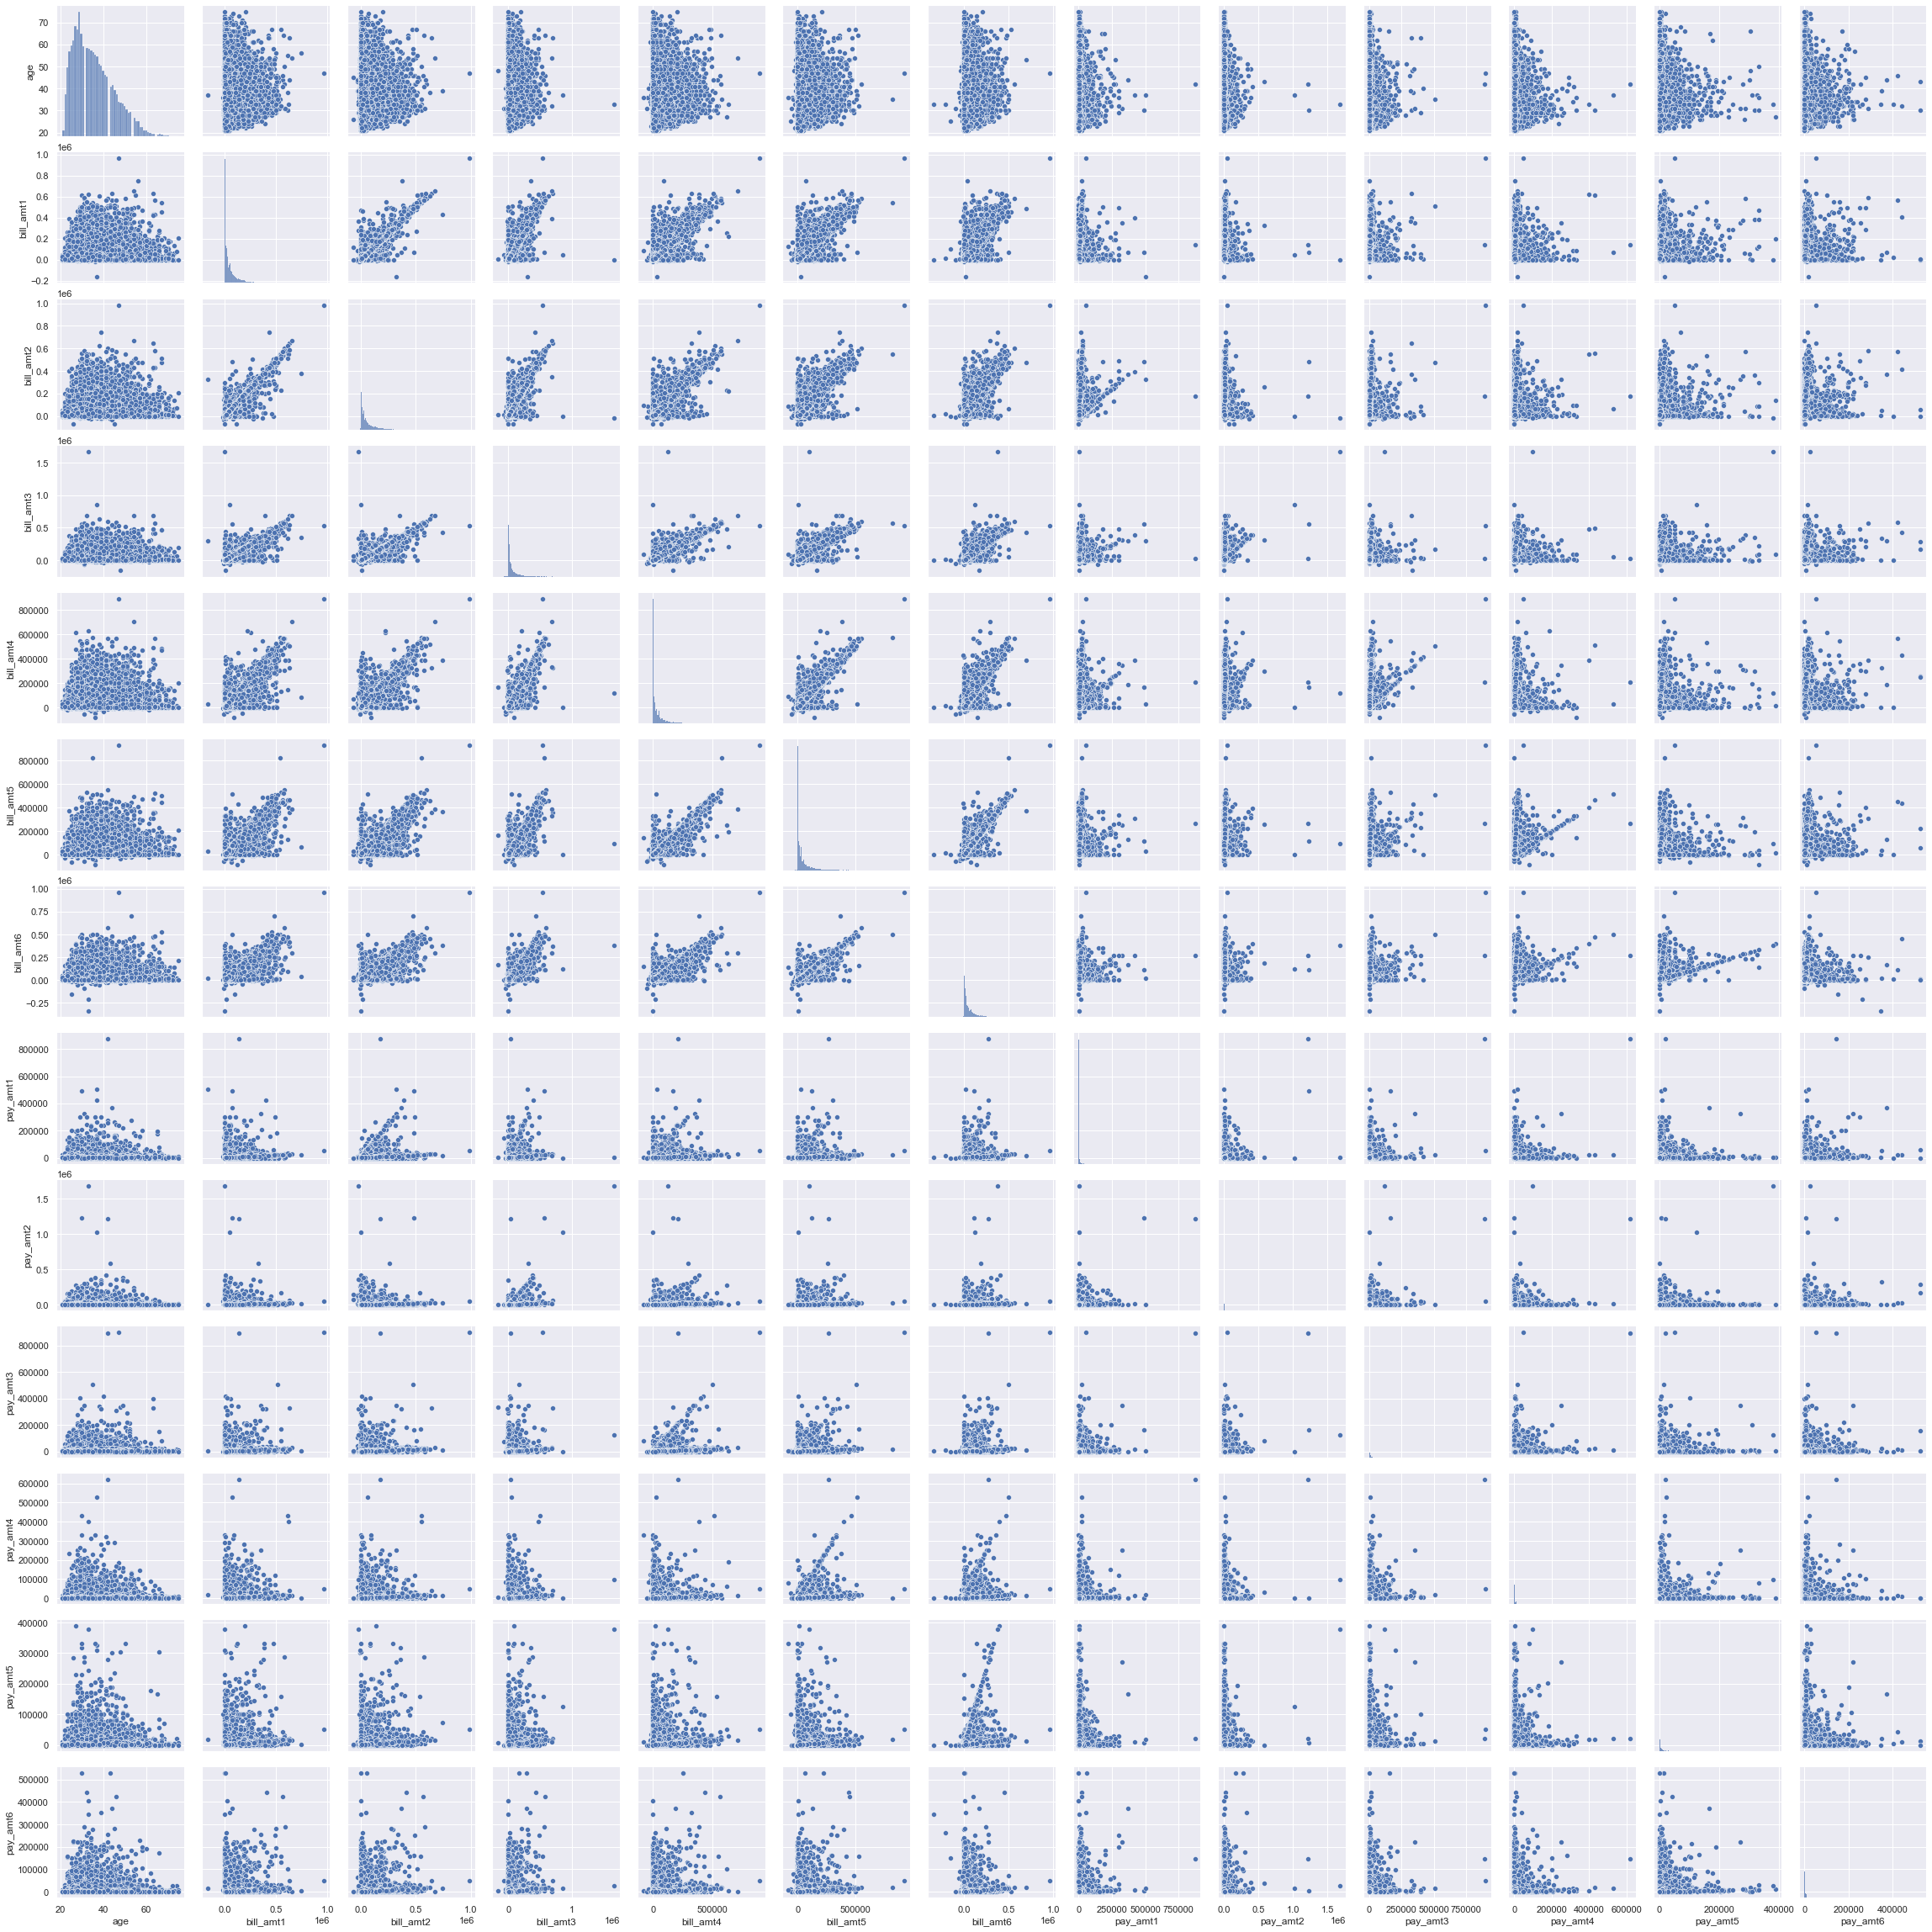

In [354]:
quantitative_features = [
                   'age', 
                   'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 
                   'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6'
]

sns.pairplot(df[quantitative_features]);

It may require a magnifying lens for analysis, but it will do well to tile my bathroom.

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22499 entries, 28835 to 7624
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   limit_bal  22499 non-null  int64
 1   sex        22499 non-null  int64
 2   education  22499 non-null  int64
 3   marriage   22499 non-null  int64
 4   age        22499 non-null  int64
 5   pay_0      22499 non-null  int64
 6   pay_2      22499 non-null  int64
 7   pay_3      22499 non-null  int64
 8   pay_4      22499 non-null  int64
 9   pay_5      22499 non-null  int64
 10  pay_6      22499 non-null  int64
 11  bill_amt1  22499 non-null  int64
 12  bill_amt2  22499 non-null  int64
 13  bill_amt3  22499 non-null  int64
 14  bill_amt4  22499 non-null  int64
 15  bill_amt5  22499 non-null  int64
 16  bill_amt6  22499 non-null  int64
 17  pay_amt1   22499 non-null  int64
 18  pay_amt2   22499 non-null  int64
 19  pay_amt3   22499 non-null  int64
 20  pay_amt4   22499 non-null  int64
 21  pay_amt5   224

In [294]:
df.describe()

ID,limit_bal,male,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,y,hs_edu,uni_edu,grad_edu
count,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,2.249900e+04,22499.000000,22499.000000,22499.000000,22499.000000,2.249900e+04,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.000000,22499.00000,22499.000000
mean,166382.047202,0.396773,0.453131,35.447931,0.175786,-0.128806,-0.160185,-0.214587,-0.259700,-0.287613,51455.869416,49385.313214,4.704213e+04,43329.149562,40306.373039,38955.000356,5627.914796,5.964393e+03,5258.912307,4792.971777,4865.656029,5247.279301,0.223477,0.984399,0.81937,0.351971
std,127707.427930,0.489239,0.497810,9.237634,1.020280,1.197954,1.198880,1.174824,1.139984,1.154249,74470.257248,71953.814345,6.991792e+04,64607.088483,60918.993067,59773.144959,16628.162287,2.444370e+04,18153.554633,15872.858180,15507.449610,17892.327398,0.416584,0.123927,0.38472,0.477596
min,10000.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-81334.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,50000.000000,0.000000,0.000000,28.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3506.000000,2975.000000,2.611500e+03,2319.500000,1732.500000,1230.000000,1000.000000,8.290000e+02,396.000000,284.000000,246.500000,100.000000,0.000000,1.000000,1.00000,0.000000
50%,140000.000000,0.000000,0.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22387.000000,21145.000000,2.005300e+04,19048.000000,18050.000000,16924.000000,2100.000000,2.004000e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.000000,1.000000,1.00000,0.000000
75%,240000.000000,1.000000,1.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66988.500000,63755.000000,6.016100e+04,54494.500000,50196.000000,49250.000000,5002.000000,5.000000e+03,4500.000000,4000.000000,4068.500000,4000.000000,0.000000,1.000000,1.00000,1.000000
max,500000.000000,1.000000,1.000000,75.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,388071.000000,528666.000000,1.000000,1.000000,1.00000,1.000000


In [111]:
currencies = [
    ['NT', 10000.00, 120000.00, 180000.00, 200000.00, 220000.00, 240000.00], 
    ['USD', 352.14, 4225.71, 6338.57, 7042.85, 7747.14, 8451.42]
]
money_chart = pd.DataFrame(currencies)
money_chart.set_index(0)

,1,2,3,4,5,6
0,,,,,,
NT,10000.00,120000.00,180000.00,200000.00,220000.00,240000.00
USD,352.14,4225.71,6338.57,7042.85,7747.14,8451.42


That translates to roughly:  
- 28.4 NT = 1 USD

Let's take a look at how the features correlate with each other.

In [297]:
df.head()

ID,limit_bal,male,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,y,hs_edu,uni_edu,grad_edu
28835,220000,0,0,36,0,0,0,0,0,0,222598,222168,217900,221193,181859,184605,10000,8018,10121,6006,10987,143779,1,1,1,1
25329,200000,0,0,29,0,-1,-1,-1,-1,-1,326,326,326,326,326,326,326,326,326,326,326,326,0,1,0,0
18894,180000,0,0,27,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
690,80000,1,0,32,0,0,0,0,0,0,51372,51872,47593,43882,42256,42527,1853,1700,1522,1548,1488,1500,0,1,1,0
6239,10000,1,0,27,0,0,0,0,0,0,8257,7995,4878,5444,2639,2697,2000,1100,600,300,300,1000,1,1,1,0


KeyboardInterrupt: 

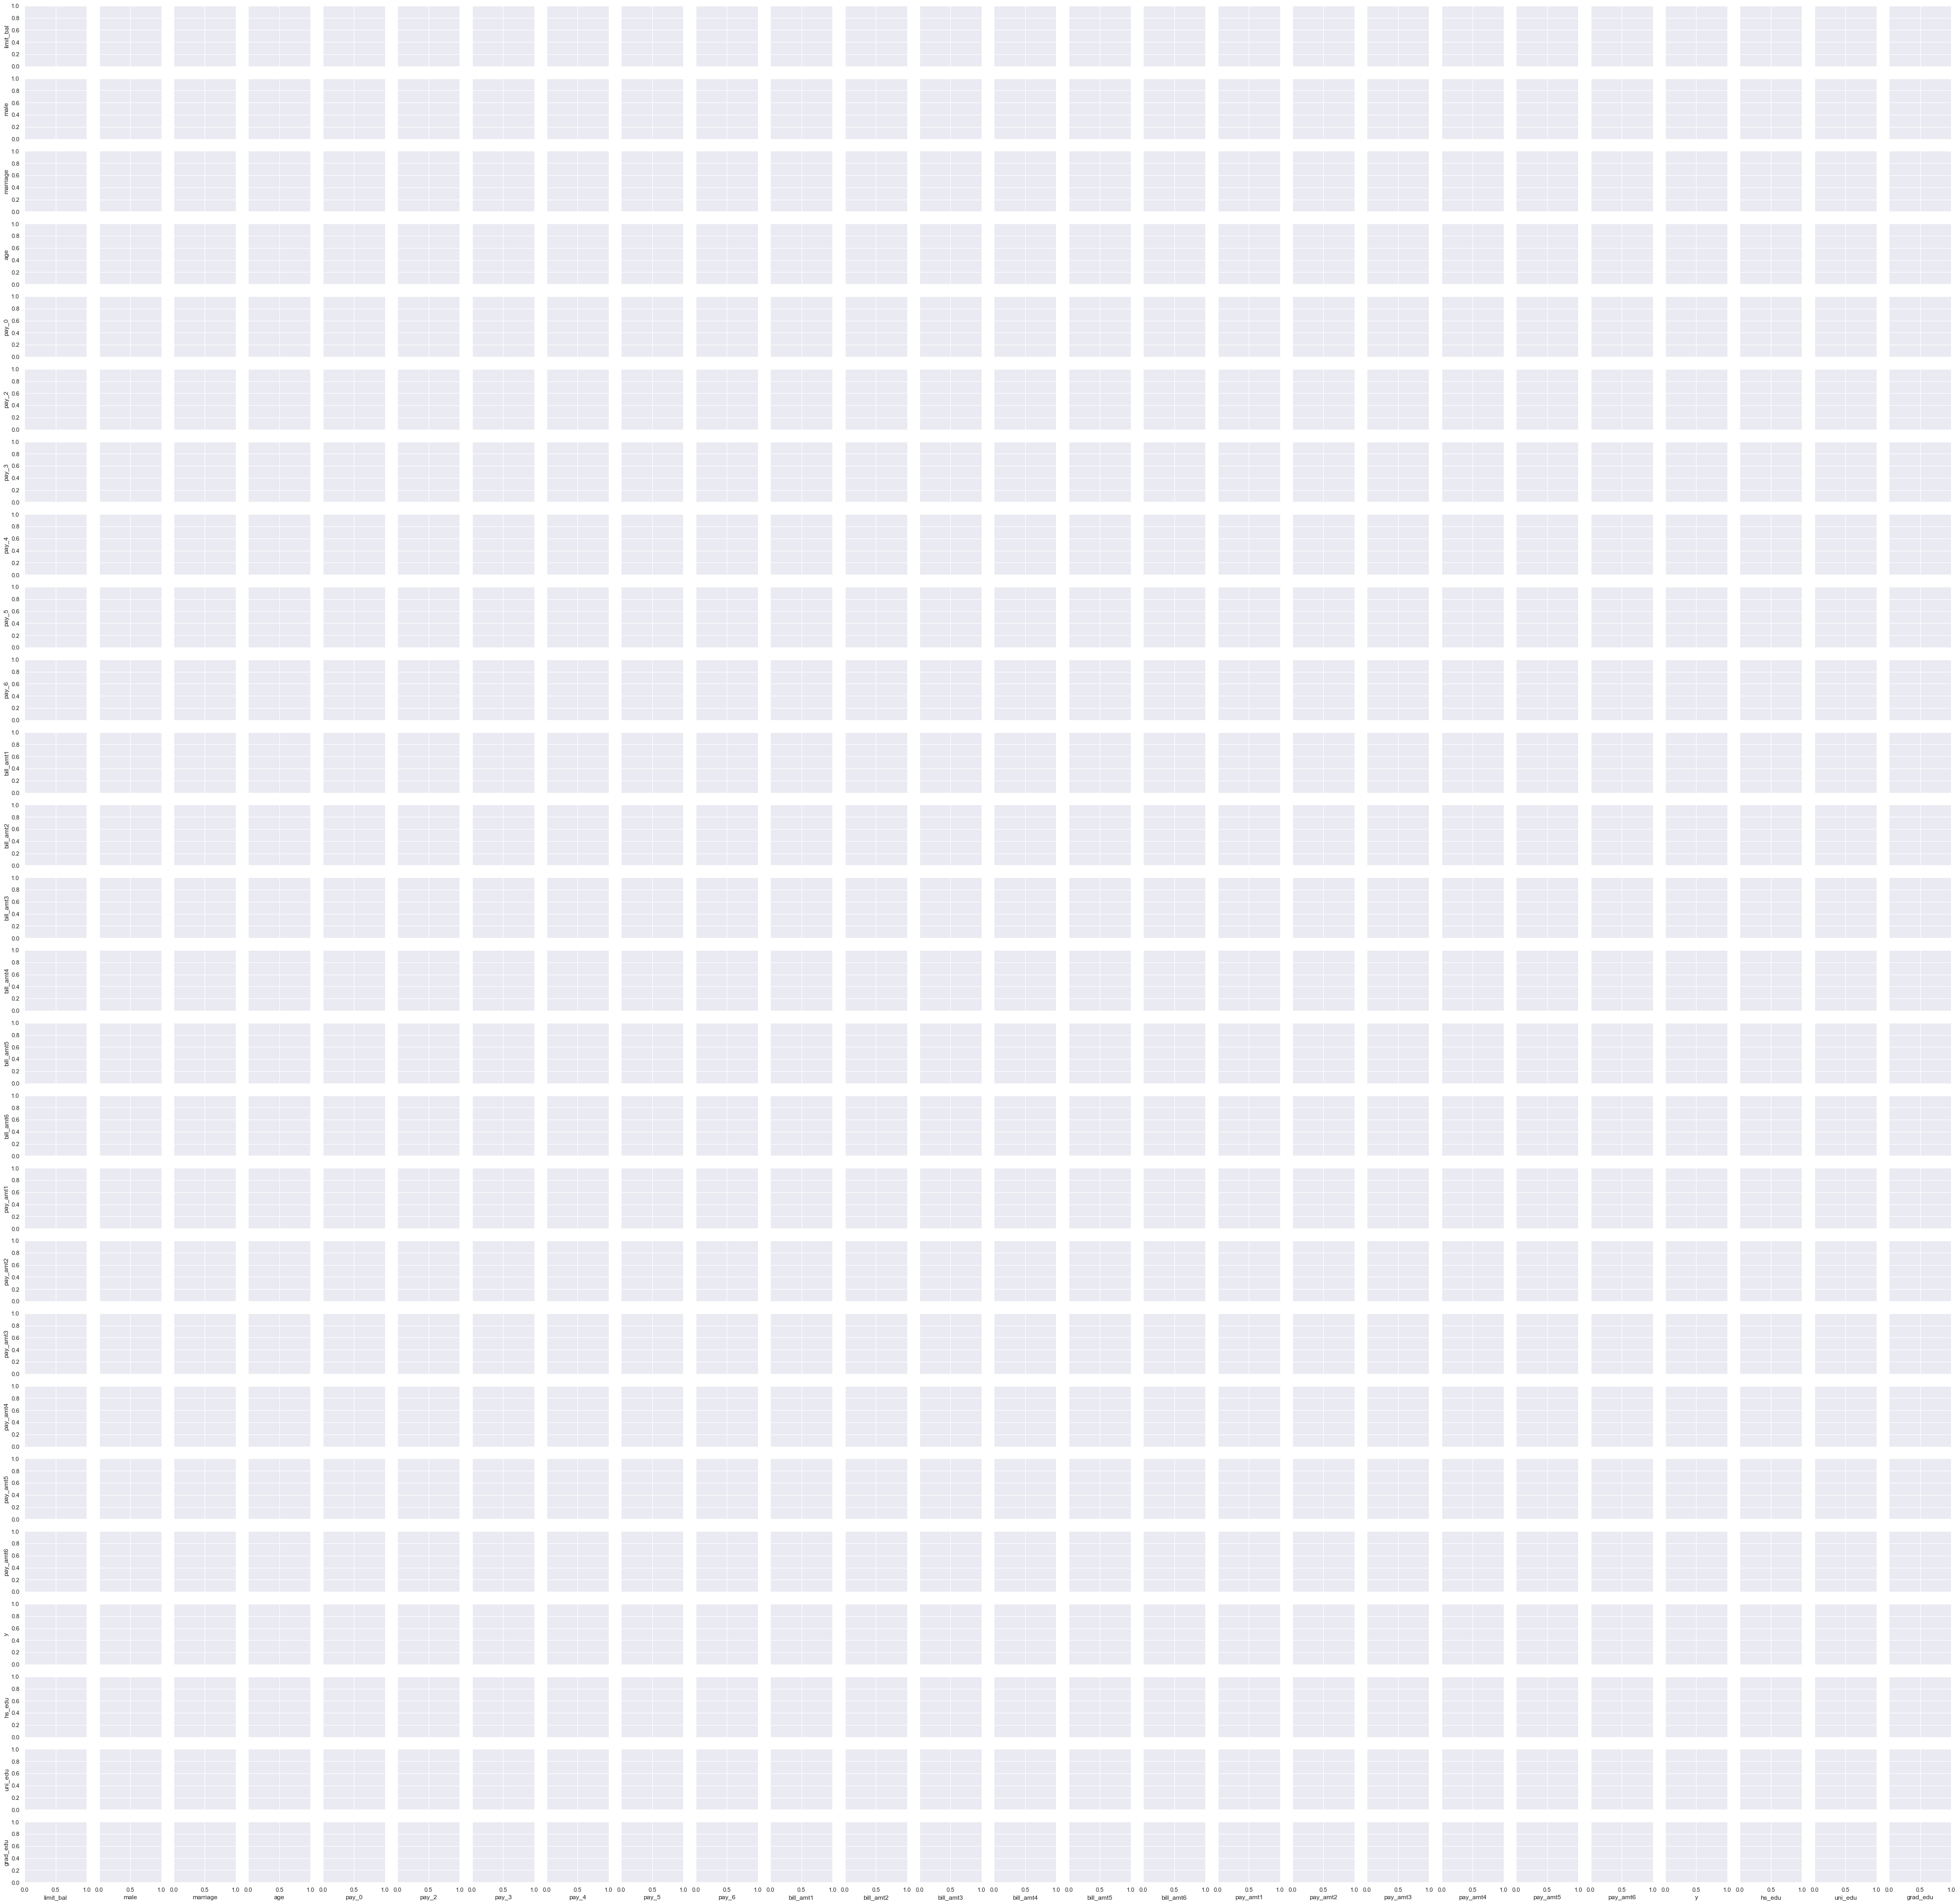

In [299]:
numeric_columns = []
sns.pairplot(df[numeric_columns]);

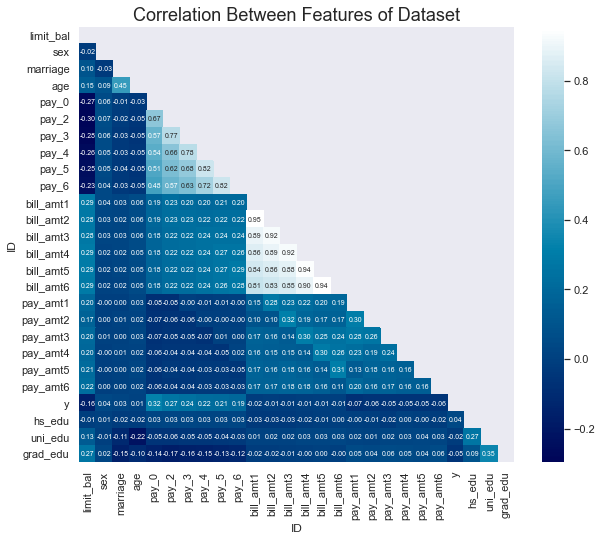

In [278]:
# Creating a correlation matrix
corr_matrix = df.corr()

# Trimming the fat
# df_slim = df.drop(columns=[])
# corr_matrix_slim = df_slim.corr()

# Creating a mask to restrict heatmap to half, improve readability by not repeating correlation values
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plotting correlation matrix as seaborn heatmap
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Correlation Between Features of Dataset', size=18)

sns.heatmap(corr_matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap='ocean', annot_kws={"size": 7});

It's difficult to notice relations between predictors as several predictors fall within a certain subcategory of another, but it's interesting to see that a person's gender and age seem to have no more than a negligible impact on their likelihood to default. Also, I would have imagined that marital status would have had a larger negative correlation with sex. 

#### X1 — limit_bal

    Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit

Values range between 10,000 and 1,000,000 ($\$$352 - $\$$35,211 USD). These credit balances appear to be akin to personal credit card limits. Were the dataset to include other forms of debt, such as mortgages and business credit cards, the values would range much higher.  
  
Also worth noting is that despite there being just about 25,000 rows of data, there are only 80 different values for balance limits. This tempts me to dummy each unique value as being its own balance limit group, rather than treating balance limits as a continuous variable.  
  
Limits tend to be set near a nice, round number, as we can see where distribution of balance limits spike. The highest *common* credit limit is 500,000, which has a count of 545. There are 154 outliers beyond that, which I will cap down to 500,000. After cleaning, there are 52 unique values for balance limits.  

In [247]:
df.limit_bal.max()

1000000

In [250]:
df.limit_bal.min()

10000

In [255]:
df.limit_bal.sort_values()

8444       10000
9347       10000
1245       10000
4495       10000
14507      10000
          ...   
10090     750000
24321     780000
28716     780000
14920     800000
2198     1000000
Name: limit_bal, Length: 22499, dtype: int64

In [274]:
df.limit_bal.value_counts().sort_values()

327680       1
16000        2
490000      46
370000      48
440000      56
          ... 
200000    1134
80000     1210
30000     1223
20000     1488
50000     2534
Name: limit_bal, Length: 52, dtype: int64

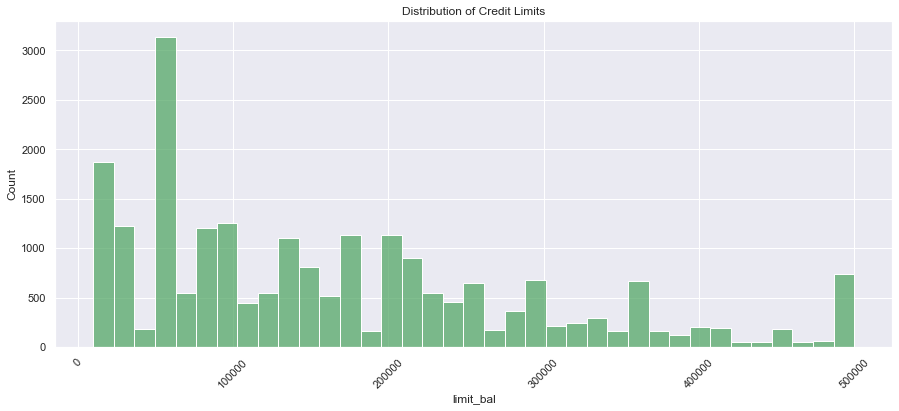

In [273]:
sns.barplot(data=df, x=df.age, y=df.age.value_counts(), ax=ax);

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Distribution of Credit Limits')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='x')
sns.histplot(df.limit_bal, 
             color = 'g', ax = ax);

In [259]:
600000/28.4

21126.76056338028

#### X2 — sex renamed to: male

Gender
- 1 — male
- 2 — female  
  
This feature would function better for the model as a boolean yes/no for one gender. I will set the column name to 'male', and set values of 2 in this column to 0.  
  
Note: Please excuse prioritization of the patriarch. 'male' is simply shorter to type, making for easier data manipulation.

In [279]:
df.columns

Index(['limit_bal', 'sex', 'marriage', 'age', 'pay_0', 'pay_2', 'pay_3',
       'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3',
       'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2',
       'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'y', 'hs_edu',
       'uni_edu', 'grad_edu'],
      dtype='object', name='ID')

#### X3 — education

  - 1 — graduate school
  - 2 — university
  - 3 — high school
  - 4 — other

Initial inspection reveals that 1-4 are not the only values given for this feature. Some rows report 0, 5 or 6 for values. I'm hesitant to imput here, however after reviewing the holdout dataset, values for 0, 5 and 6 are consistent there as well, and I will not be able to drop values from the holdout dataset.  
  
My assumption would be that 0 is no education, and should be imputed to 4/ "other". Likewise for 5 and 6, imputing 4/ "other" in place of these values would be appropriate, despite the difficulty in discerning the true intention behind them.  

In [184]:
df.education.value_counts()

2    10516
1     7919
3     3713
5      208
4       90
6       42
0       11
Name: education, dtype: int64

#### X4 — marriage

    Marital status 
- 1 — married
- 2 — single
- 3 — other

There are 44 rows that have zero for a value, which has no given description. Rather than impute a meaning to zero and "3/other," I will set all values that are *not* married to zero, making the category a binary "1/married" or "0/not married."

In [276]:
df.marriage.value_counts()

2    12026
1    10195
3      234
0       44
Name: marriage, dtype: int64

In [277]:
df.marriage.value_counts()

0    12304
1    10195
Name: marriage, dtype: int64

#### X5 — age

Age in years. Numerical values that are quantitative. This feature seems to be fairly clean, with no values for below age 21, and no values above age 75. Holding a credit balance appears to be more popular at ages younger than 30, then begin to steadily decline with age.

In [204]:
df[df.age < 21]

ID,limit_bal,sex,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,y,hs_edu,uni_edu,grad_edu


In [199]:
df[df.age > 70]

ID,limit_bal,sex,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,y,hs_edu,uni_edu,grad_edu
27542,250000,1,1,71,0,0,0,0,0,0,173907,177484,177946,159849,145461,141487,6504,6243,5446,4721,4385,7805,0,1,1,1
6024,70000,0,1,71,0,0,0,2,0,0,64670,66197,70867,54425,55555,48530,3166,6550,0,2033,1915,1708,0,1,0,0
388,80000,1,1,73,-1,0,0,2,2,2,63144,65631,68875,70646,72870,75018,3500,4330,3500,3500,3500,5100,1,1,0,0
29176,160000,0,1,74,0,0,0,-1,-1,-1,79201,69376,66192,16905,0,19789,3783,2268,16905,0,19789,26442,0,1,0,0
29180,500000,0,1,73,-2,-2,-2,-2,-2,-2,0,2826,2652,2835,8896,3850,2826,2652,2835,8896,3850,711,1,1,1,0
1645,50000,1,1,72,2,0,0,0,2,2,35417,36453,37166,39710,40519,41324,1908,1621,3165,1600,1620,0,1,1,0,0
25142,210000,1,1,75,0,0,0,0,0,0,205601,203957,199882,203776,205901,210006,9700,8810,9000,7300,7500,7600,0,1,1,0
25143,300000,1,1,72,-1,-1,-1,-1,-1,2,4984,752,3737,1433,5522,3233,756,3753,1433,5522,0,27232,0,1,0,0
10700,140000,1,1,73,0,0,0,0,0,0,135206,135316,134943,135772,138675,137197,5082,5008,5000,6016,5018,5264,0,1,1,0
25137,180000,1,1,75,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1


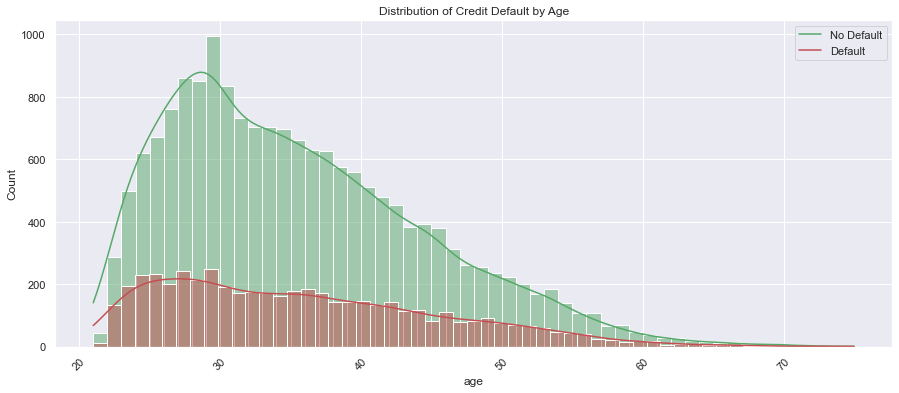

In [235]:
sns.barplot(data=df, x=df.age, y=df.age.value_counts(), ax=ax);

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Distribution of Credit Default by Age')
plt.xticks(rotation=45)
sns.histplot(df[df.y == 0].age, 
             color = 'g', label = 'No Default', kde=True, ax = ax)
sns.histplot(df[df.y == 1].age, 
             bins = 55, color = 'r', label = 'Default', kde=True, ax = ax)
ax.legend(labels=['No Default', 'Default']);

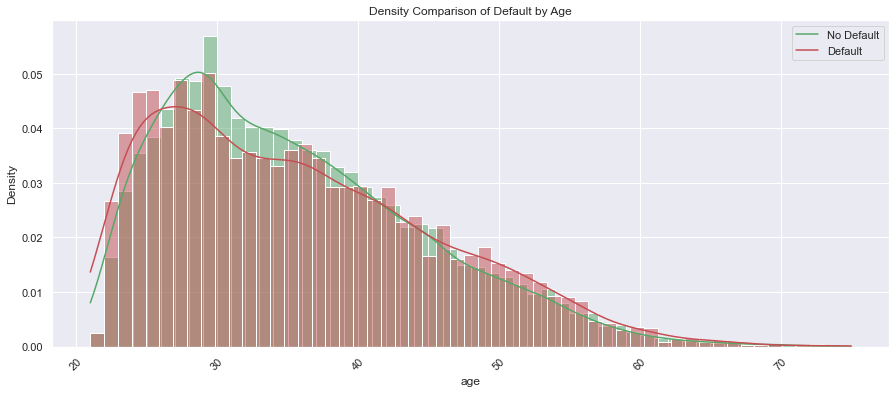

In [238]:
sns.barplot(data=df, x=df.age, y=df.age.value_counts(), ax=ax);

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Density Comparison of Default by Age')
plt.xticks(rotation=45)
sns.histplot(df[df.y == 0].age, 
             color = 'g', label = 'No Default', kde=True, stat='density', ax = ax)
sns.histplot(df[df.y == 1].age, 
             bins = 55, color = 'r', label = 'Default', kde=True, stat='density', ax = ax)
ax.legend(labels=['No Default', 'Default']);

In [231]:
df.groupby('age')['y'].value_counts()

age  y
21   0     44
     1     12
22   0    288
     1    132
23   0    497
         ... 
73   1      2
     0      1
74   0      1
75   0      1
     1      1
Name: y, Length: 108, dtype: int64

#### X6 - X11 — payment history

Categorical values. There are values of -2 and 0 for several months, which are undefined. The most likely interpretation is that negative values are different standards of paying duly (i.e., paid minimum/partial balance and paid balance in full). It could also be data entry error, but seeing as -2 and 0 are consistent values across all pay_$n$ features, I feel confident with my inferrence.  
  
Curiously even further, there are no values of 9, despite being defined with the dataset.  The median value for all months is 0. I also noticed that, for some reason, the count of 2 month pay delays for all months dwarf the count of any other pay delays, to the point where most others have value counts of less than 100. These quirks may cause some puzzling results, so I impute all pay_$n$ values that are greater than 0 to the same number (1), leaving the three paid duly groups untouched.
  
As these numeric value can be understood as categorical groupings, each group will be converted in to a dummy variable, or used to engineer a new feature.
  
I would also like to note for the record: the fact that the column names taken from the row of header-values jumped from pay_0 to pay_2 is going to haunt me, so I will rename pay_0 to pay_1, consistent with the other features that reference September.

Original feature description reference:  

     The past monthly payment records (retroactive, from April to September, 2005) as foll-ows:  
     
- X6 - **pay_1** — the repayment status in September, 2005
- X7 - **pay_2** — the repayment status in August, 2005
- X8 - **pay_3** — the repayment status in July, 2005
- X9 - **pay_4** — the repayment status in June, 2005
- X10 - **pay_5** — the repayment status in May, 2005
- X11 - **pay_6** — the repayment status in April, 2005  
  
      The measurement scale for the repayment status is:
- -1 — pay duly
- 1 — payment delay for one month
- 2 — payment delay for two months
- 3 — payment delay for three months
- 4 — payment delay for four months
- 5 — payment delay for five months
- 6 — payment delay for six months
- 7 — payment delay for seven months
- 8 — payment delay for eight months
- 9 — payment delay for nine months and above

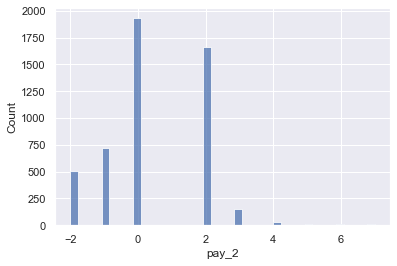

In [363]:
sns.histplot(df.pay_2[df.y == 1]);

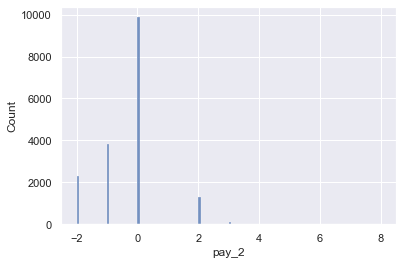

In [364]:
sns.histplot(df.pay_2[df.y == 0]);

In [346]:
df.pay_3.value_counts()

 0    11823
-1     4464
-2     3024
 2     2891
 3      177
 4       58
 7       22
 6       19
 5       15
 1        4
 8        2
Name: pay_3, dtype: int64

In [338]:
df.pay_6.median()

0.0

In [358]:
df.pay_6.value_counts()

 0    12233
-1     4284
-2     3663
 2     2078
 3      140
 7       38
 4       38
 6       14
 5        9
 8        2
Name: pay_6, dtype: int64

In [288]:
df.pay_2.value_counts()

 0    11804
-1     4526
 2     2967
-2     2813
 3      251
 4       70
 1       24
 5       19
 7       16
 6        8
 8        1
Name: pay_2, dtype: int64

#### X12 - X17 — bill_amt $n$

There are negative values for each month of bill statements. This isn't remarkably peculiar as it should simply mean that the individual overpaid their balance, but I wonder if imputing this to 0 would be 

    Amount of bill statement (NT dollar)  
- X12 — **bill_amt1** — amount of bill statement in September, 2005
- X13 — **bill_amt2** — amount of bill statement in August, 2005
- X14 — **bill_amt3** — amount of bill statement in July, 2005
- X15 — **bill_amt4** — amount of bill statement in June, 2005
- X16 — **bill_amt5** — amount of bill statement in May, 2005
- X17 — **bill_amt6** — amount of bill statement in April, 2005

In [377]:
df.bill_amt1

28835    222598
25329       326
18894         0
690       51372
6239       8257
          ...  
16247     35183
2693       3800
8076          0
20213      5141
7624      11729
Name: bill_amt1, Length: 22499, dtype: int64

In [384]:
df[df.bill_amt1 < 0].bill_amt1.min()/28.4

-5830.281690140845

Someone overpaid their credit card by *nearly $\$$6,000 USD FUCK*.

In [375]:
df[(df.bill_amt1 < 1000) & (df.bill_amt1 > 0)]

ID,limit_bal,male,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,y,hs_edu,uni_edu,grad_edu
25329,200000,0,0,29,-1,-1,-1,-1,-1,-1,326,326,326,326,326,326,326,326,326,326,326,326,0,1,0,0
11593,260000,0,0,27,-1,-1,-1,-1,0,-1,399,399,399,798,399,399,399,399,798,0,399,399,0,1,1,1
22167,170000,0,0,27,-1,-1,1,-1,-1,-1,356,1472,736,736,736,736,1536,0,736,736,736,736,0,1,1,1
26307,210000,0,0,29,-1,-1,-1,-1,-1,1,871,27371,871,871,2042,1021,27371,871,871,2042,0,1666,0,1,1,1
8015,330000,0,1,36,-1,-1,-1,-1,-1,-1,399,26,519,452,457,0,26,707,452,457,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5297,500000,0,1,33,-2,-2,-1,-1,-2,-1,125,-18088,1664089,121757,97115,377217,4366,1684259,121831,97670,379267,26759,0,1,1,1
12146,200000,0,1,38,-1,-1,-1,-1,-1,-1,780,0,390,390,390,390,0,390,390,390,390,390,0,1,1,0
17101,60000,0,0,24,1,1,1,1,1,-1,150,150,150,150,150,150,0,0,0,0,150,44399,1,1,1,0
4908,40000,0,1,43,-1,-1,-1,-1,-1,-1,220,960,960,960,1383,960,960,960,960,1383,960,960,0,1,1,0


In [376]:
1000/28.4

35.21126760563381

#### X18 - X23 — pay_amt $n$

    Amount of previous payment (NT dollar)  
- X18 — **pay_amt1** — amount paid in September, 2005
- X19 — **pay_amt2** — amount paid in August, 2005
- X20 — **pay_amt3** — amount paid in July, 2005
- X21 — **pay_amt4** — amount paid in June, 2005
- X22 — **pay_amt5** — amount paid in May, 2005
- X23 — **pay_amt6** — amount paid in April, 2005

### Descriptions of Dataset Features

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables: 
- <b>X1</b> — Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit 
- <b>X2</b> — Gender: 
  - 1 — male
  - 2 — female
- <b>X3</b> — Education:
  - 1 — graduate school
  - 2 — university
  - 3 — high school
  - 4 — other
- <b>X4</b> — Marital status 
  - 1 — married
  - 2 — single
  - 3 — others  
- <b>X5</b> — Age (year) 
- <b>X6 - X11</b> — History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
    - X6 — the repayment status in September, 2005
    - X7 — the repayment status in August, 2005
    - ...
    - X11 — the repayment status in April, 2005 
      
      The measurement scale for the repayment status is:
      - -1 — pay duly
      - 1 — payment delay for one month 
      - 2 — payment delay for two months
      - ...
      - 8 — payment delay for eight months
      - 9 — payment delay for nine months and above
- <b>X12-X17</b> — Amount of bill statement (NT dollar)
    - X12 — amount of bill statement in September, 2005
    - ...
    - X13 — amount of bill statement in August, 2005
    - X17 — amount of bill statement in April, 2005 
- <b>X18-X23</b> — Amount of previous payment (NT dollar) 
    - X18 — amount paid in September, 2005
    - X19 — amount paid in August, 2005
    - ...
    - X23 — amount paid in April, 2005 

## Feature Engineering

The **limit_bal** feature (formerly X1) has 52 unique values after cleaning. I will create dummy variables for each of these for my model, treating each value as a categorical group rather than a continuous variable.  

The **education** feature (formerly X3) would be more workable as dummy variables. I will create three new features  for graduate school, university, and high school education status. For those that have high school education, they will receive a "1" in `hs_edu` and a zero for the other two. For those with university education, they will receive a "1" for both `uni_edu` and `hs_edu`. Graduate school educated will get "1" for all three. Others will get a zero for all three.  
  
This is of course playing off of the assumption that all graduate students have attended university, and all university students have attended high school. Presuming that the education system in Taiwan is similar to that in the United States, this would be the case a significant majority of the time.  

The **pay_$n$** features (formerly X6-11) are categorical and will be converted in to dummy variables.

In [190]:
df.head()

ID,limit_bal,sex,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,y,hs_edu,uni_edu,grad_edu
28835,220000,0,2,36,0,0,0,0,0,0,222598,222168,217900,221193,181859,184605,10000,8018,10121,6006,10987,143779,1,1,1,1
25329,200000,0,2,29,-1,-1,-1,-1,-1,-1,326,326,326,326,326,326,326,326,326,326,326,326,0,1,0,0
18894,180000,0,2,27,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
690,80000,1,2,32,0,0,0,0,0,0,51372,51872,47593,43882,42256,42527,1853,1700,1522,1548,1488,1500,0,1,1,0
6239,10000,1,2,27,0,0,0,0,0,0,8257,7995,4878,5444,2639,2697,2000,1100,600,300,300,1000,1,1,1,0


## Feature Selection

## Model Fitting and Hyperparameter Tuning

KNN, Logistic Regression, Decision Tree

## Model Evaluation

## Final Model

## Project Guidelines

### Applying Classification Modeling  

The goal of this week's assessment is to find the model which best predicts whether or not a person will default on their bank loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 

#### Data Set Information:

This research aimed at the case of customers default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. Because the real probability of default is unknown, this study presented the novel Sorting Smoothing Method to estimate the real probability of default. With the real probability of default as the response variable (Y), and the predictive probability of default as the independent variable (X), the simple linear regression result (Y = A + BX) shows that the forecasting model produced by artificial neural network has the highest coefficient of determination; its regression intercept (A) is close to zero, and regression coefficient (B) to one. Therefore, among the six data mining techniques, artificial neural network is the only one that can accurately estimate the real probability of default. 
- NT is the abbreviation for New Taiwain. 


#### Attribute Information:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables: 
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- X2: Gender (1 = male; 2 = female). 
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- X4: Marital status (1 = married; 2 = single; 3 = others). 
- X5: Age (year). 
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
    - X6 = the repayment status in September, 2005; 
    - X7 = the repayment status in August, 2005; . . .;
    - etc...
    - X11 = the repayment status in April, 2005. 
      
      The measurement scale for the repayment status is:  
      - -1 = pay duly; 
      - 1 = payment delay for one month; 
      - 2 = payment delay for two months; 
      - . . .; 
      - 8 = payment delay for eight months; 
      - 9 = payment delay for nine months and above. 
- X12-X17: Amount of bill statement (NT dollar). 
    - X12 = amount of bill statement in September, 2005;
    - etc...
    - X13 = amount of bill statement in August, 2005; . . .; 
    - X17 = amount of bill statement in April, 2005. 
- X18-X23: Amount of previous payment (NT dollar). 
    - X18 = amount paid in September, 2005; 
    - X19 = amount paid in August, 2005; . . .;
    - etc...
    - X23 = amount paid in April, 2005. 

You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) to predict credit card defaults and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


### Presentation

1. Clean up your data set so that you can perform an EDA. 
    - This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Engineer new features. 
    - Create polynomial and/or interaction features. 
    - Additionaly, you must also create **at least 2 new features** that are not interactions or polynomial transformations. 
        - *For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.*
4. Perform some feature selection. 
    
5. You must fit **three** models to your data and tune **at least 1 hyperparameter** per model. 
6. Using the F-1 Score, evaluate how well your models perform and identify your best model.
7. Using information from your EDA process and your model(s) output provide insight as to which borrowers are more likely to deafult
